In [4]:
import yfinance as yf
import pandas as pd
import xlrd
import cvxpy as cp
import numpy as np
import tqdm
import logging
import warnings
import plotly.express as px
import nbformat
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "jupyterlab+png"

# Load Data

## Market Data

In [5]:
# Read daily price data

market_price_df = pd.read_parquet("data/processed/daily_data.parquet", engine="fastparquet")
market_price_df.columns = [col[0] for col in market_price_df.columns] # Fix column formatting
market_price_df = market_price_df.set_index("Date") # Set Date as index

### Missing Values

Missing value behavior is analyzed to determine the missing data tolerance threshold.

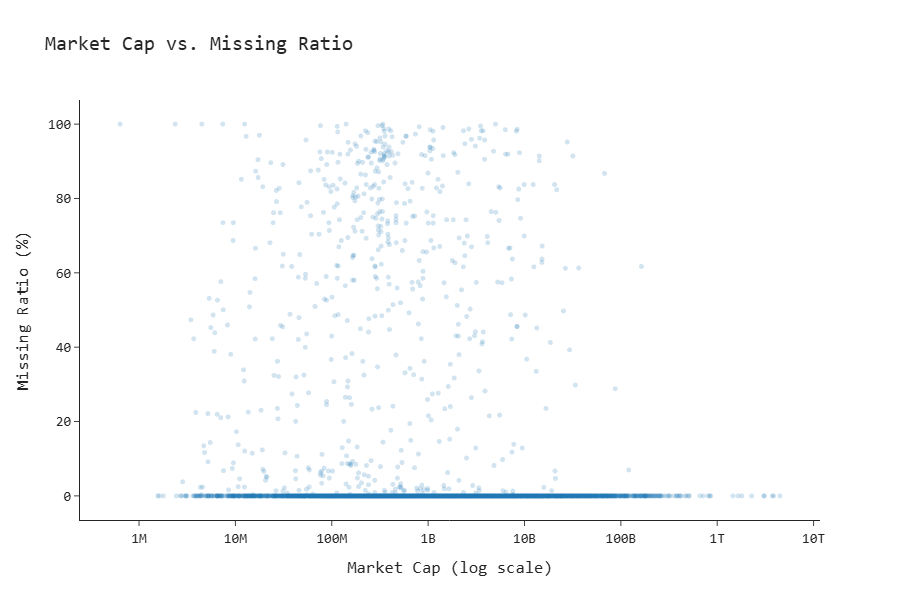

In [6]:
# Calculate missing value ratio

missing_ratio = market_price_df.isna().mean()*100 
missing_ratio.name = "Missing Ratio"

# Join with full stock metadata

inclusions_df = pd.read_parquet("data/processed/inclusions.parquet")
inclusions_df = inclusions_df.join(missing_ratio, on = "Symbol")

# Plot market cap vs. missing ratio

fig = px.scatter(
    inclusions_df,
    x="Market Cap",
    y="Missing Ratio",
    title="Market Cap vs. Missing Ratio",
    hover_name="Symbol",
    hover_data="Security Name",
    log_x=True,
    template="simple_white"
)

fig.update_traces(marker=dict(size=5, opacity=0.2))
fig.update_layout(font=dict(size=14, family = 'monospace'))
fig.update_layout(
    xaxis_title="Market Cap (log scale)",
    yaxis_title="Missing Ratio (%)",
    width=900,
    height=600
)

fig.show()

Most stocks seem to have no missing values, and the upper echelon of stocks all have no missing values.

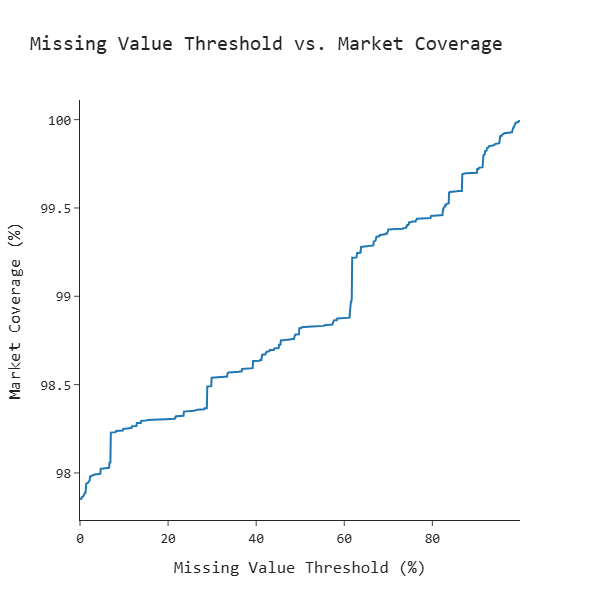

In [7]:
# Determine market coverage under different thresholds for tolerated missing values

coverage = {}
thresholds = {}
total_market_cap = sum(inclusions_df["Market Cap"]) # Calculate total market cap as sum of market caps

# Test for missing value thresholds of 0% through 100%

for threshold in range(0, 1000):
    filtered_market = inclusions_df[inclusions_df["Missing Ratio"] <= threshold/10]
    coverage[threshold] = 100*sum(filtered_market["Market Cap"])/total_market_cap
    thresholds[threshold] = threshold/10

coverage_curve = pd.DataFrame({"Coverage" : coverage, "Threshold": thresholds})

# Plot missing value ratio vs. market coverage

fig = px.line(
    coverage_curve,
    x = "Threshold",
    y = "Coverage",
    title = "Missing Value Threshold vs. Market Coverage",
    template = "simple_white"
)
fig.update_layout(font=dict(size=14, family = 'monospace'))
fig.update_layout(
    xaxis_title="Missing Value Threshold (%)",
    yaxis_title="Market Coverage (%)",
    width=600,
    height=600
)

fig.show()

Missing value threshold of 0% (removing all stocks with any missing value) results in a 97.8524% market coverage. Coverage increases somewhat linearly, with a few jumps. For simplicity, 0% missing value tolerance is selected.

In [8]:
print("Stocks before missing value filter:", market_price_df.shape[1])
market_price_df = market_price_df.dropna(axis=1)
print("Stocks after missing value filter:", market_price_df.shape[1])

# Obtain daily market returns

market_returns_df = market_price_df.pct_change().drop(index = market_price_df.index[0])

Stocks before missing value filter: 4294
Stocks after missing value filter: 3705


## Index Data

In [9]:
# Read index data

files = [f"data/raw/historyIndex ({i}).xls" for i in range(1, 5)]

dates_list, values_list, names = [], [], []

# Parse table for each file for name, date and value data

for file in files:
    book = xlrd.open_workbook(file)
    sheet = book.sheet_by_index(0)

    name = None
    dates, values = [], []
    table_started = False

    for r in range(sheet.nrows):
        cell = sheet.row(r)[0].value

        if not table_started and cell == 'Date':
            name = sheet.row(r)[1].value
            table_started = True
        elif table_started and cell != '':
            dates.append(cell)
            values.append(sheet.row(r)[1].value)
        else:
            table_started = False

    names.append(name)
    dates_list.append(dates)
    values_list.append(values)

# Create aggregated DataFrame

data = {'Date': dates_list[0], **{n: v for n, v in zip(names, values_list)}}
index_gross_df = pd.DataFrame(data)

# Remove numerical commas

for n in names:
    index_gross_df[n] = (pd.to_numeric(index_gross_df[n].astype(str).str.replace(',', ''), errors='coerce'))

# Match index Date column with daily market Date column 

index_gross_df['Date'] = pd.to_datetime(index_gross_df['Date'])
index_gross_df = index_gross_df[index_gross_df['Date'].isin(market_price_df.index)]
index_gross_df = index_gross_df.set_index('Date')

# Obtain daily index returns

index_returns_df = index_gross_df.pct_change().drop(index = index_gross_df.index[0])

# Optimization

In [10]:
A = market_returns_df.values
b = index_returns_df["USA Standard (Large+Mid Cap)"].values
n = A.shape[0]
m = A.shape[1]

A_close = market_price_df.values
b_gross = index_gross_df["USA Standard (Large+Mid Cap)"].values
real_dates = index_gross_df.index
initial_value = b_gross[0]

## Naive Approaches

Since USA Standard is representative of the USA market, naive approaches such as equally-weighted or cap-weighted portfolios move similarly to the index.

### Equal weights

In [11]:
# Calculate equal weights

equal_weights = [1/m]*m

# Calculate cap-weighted tracker returns and values

equal_weights_tracker_returns = A @ equal_weights 
equal_weights_tracker_value = initial_value * (1 + np.insert(equal_weights_tracker_returns, 0, 0)).cumprod()
equal_weights_tracker_value_df = pd.DataFrame({"Equal Weights Tracker": equal_weights_tracker_value}, index=real_dates)

MSE = 0
MAE = 0
for i in range(n):
    MSE += (equal_weights_tracker_returns[i] - b[i])**2
    MAE += abs(equal_weights_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)

MSE: 4.32942362482974e-05
MAE: 0.005158875951234072


### Cap-weighted

In [12]:
# Calculate cap weights

market_cap_dict = inclusions_df[inclusions_df["Symbol"].isin(market_price_df.columns)][["Symbol", "Market Cap"]].set_index("Symbol").to_dict()["Market Cap"]

cap_weights = []
for symbol in market_returns_df.columns:
    cap_weights.append(market_cap_dict[symbol]/sum(market_cap_dict.values()))

# Calculate cap-weighted tracker returns and values

cap_weighted_tracker_returns = A @ cap_weights
cap_weighted_tracker_value = initial_value * (1 + np.insert(cap_weighted_tracker_returns, 0, 0)).cumprod()
cap_weighted_tracker_value_df = pd.DataFrame({"Cap-weighted Tracker": cap_weighted_tracker_value}, index=real_dates)

# MSE and MAE for returns

MSE = 0
MAE = 0
for i in range(n):
    MSE += (cap_weighted_tracker_returns[i] - b[i])**2
    MAE += abs(cap_weighted_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)

MSE: 7.723134861173194e-06
MAE: 0.0020190926479064938


## Least Squares
Least squares regression can be employed given by finding w such that A*w approximates b, where A are the market returns and be are the index returns.

In [13]:
# Formulate and solve optimization problem

w = cp.Variable(A.shape[1])

objective = cp.Minimize(cp.sum_squares(A @ w - b))
constraints = [0 <= w, cp.sum(w) == 1] # Positive weights, sum(weights) = 1.
prob = cp.Problem(objective, constraints)

prob.solve()

0.00036359302922797654

In [14]:
# Fetch least squares weights
# cvxpy optimization can result in floating point inaccuracies

ls_weights = np.clip(w.value, 0, 1) # Clip weights outside [0, 1]
ls_weights /= sum(ls_weights) # Re-normalize weights

# Calculate cap-least squares tracker returns and values

ls_tracker_returns = A @ ls_weights
ls_tracker_value = initial_value * (1 + np.insert(ls_tracker_returns, 0, 0)).cumprod()
ls_tracker_value_df = pd.DataFrame({"Least Squares Tracker": ls_tracker_value}, index=real_dates)

# MSE and MAE for returns

MSE = 0
MAE = 0
for i in range(n):
    MSE += (ls_tracker_returns[i] - b[i])**2
    MAE += abs(ls_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)


MSE: 3.7414404183367294e-07
MAE: 0.00047741847300778714


## USA Standard Results

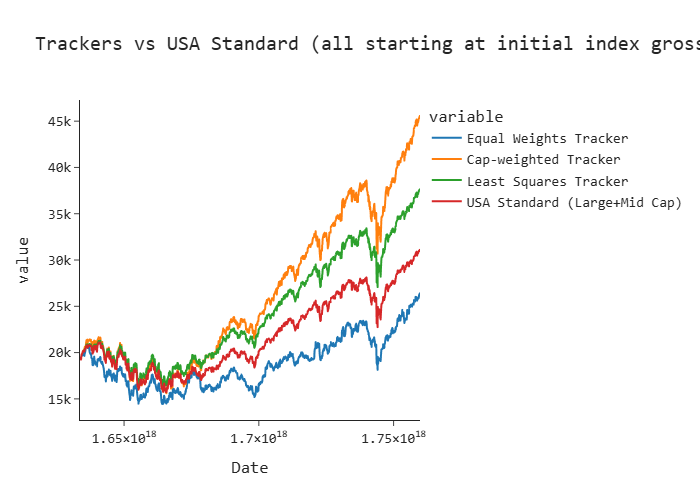

In [15]:
df_plot = pd.concat([
    equal_weights_tracker_value_df,
    cap_weighted_tracker_value_df,
    ls_tracker_value_df,
    index_gross_df["USA Standard (Large+Mid Cap)"]
], axis=1)

fig = px.line(df_plot, title = "Trackers vs USA Standard (all starting at initial index gross)", template="simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))

fig.show()


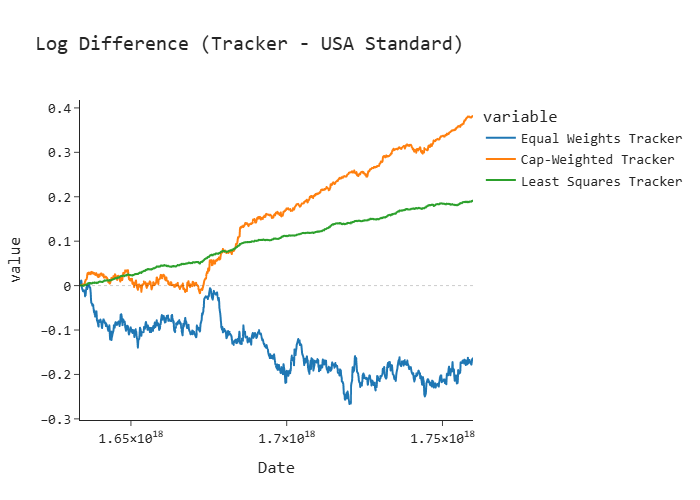

In [16]:
log_diff_df = pd.concat([
    np.log(equal_weights_tracker_value) - np.log(index_gross_df["USA Standard (Large+Mid Cap)"]),
    np.log(cap_weighted_tracker_value) - np.log(index_gross_df["USA Standard (Large+Mid Cap)"]),
    np.log(ls_tracker_value) - np.log(index_gross_df["USA Standard (Large+Mid Cap)"])
], axis = 1)

log_diff_df.columns = [
    "Equal Weights Tracker",
    "Cap-Weighted Tracker", 
    "Least Squares Tracker"]

fig = px.line(log_diff_df, title = "Log Difference (Tracker - USA Standard)", template = "simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))
fig.add_hline(y=0, opacity=0.2, line_width=1, line_dash='dot')
fig.show()


## Least Squares on Other indices

### USA QUALITY Standard

In [17]:
A = market_returns_df.values
b = index_returns_df["USA QUALITY Standard (Large+Mid Cap)"].values
n = A.shape[0]
m = A.shape[1]

A_close = market_price_df.values
b_gross = index_gross_df["USA QUALITY Standard (Large+Mid Cap)"].values
real_dates = index_gross_df.index
initial_value = b_gross[0]

In [18]:
# Formulate and solve optimization problem

w = cp.Variable(A.shape[1])

objective = cp.Minimize(cp.sum_squares(A @ w - b))
constraints = [0 <= w, cp.sum(w) == 1] # Positive weights, sum(weights) = 1.
prob = cp.Problem(objective, constraints)

prob.solve()

0.0007756300230933964

In [19]:
# Fetch least squares weights
# cvxpy optimization can result in floating point inaccuracies

ls_weights = np.clip(w.value, 0, 1) # Clip weights outside [0, 1]
ls_weights /= sum(ls_weights) # Re-normalize weights

# Calculate cap-least squares tracker returns and values

ls_tracker_returns = A @ ls_weights
ls_tracker_value = initial_value * (1 + np.insert(ls_tracker_returns, 0, 0)).cumprod()
ls_tracker_value_df = pd.DataFrame({"Least Squares Tracker": ls_tracker_value}, index=real_dates)

# MSE and MAE for returns

MSE = 0
MAE = 0
for i in range(n):
    MSE += (ls_tracker_returns[i] - b[i])**2
    MAE += abs(ls_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)


MSE: 7.844043383075082e-07
MAE: 0.0006688384557575062


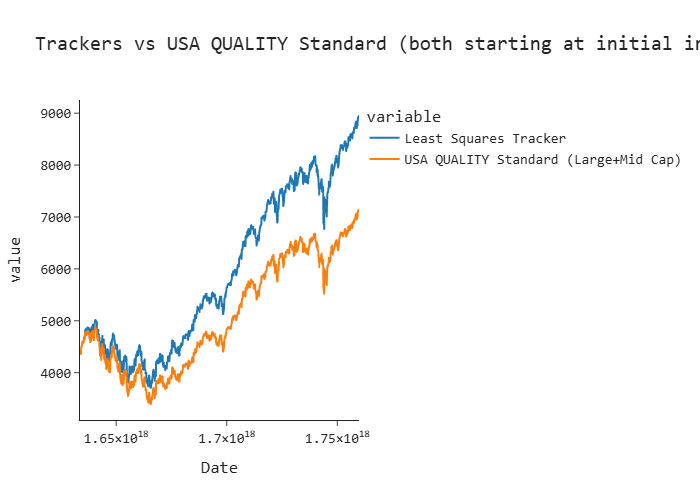

In [20]:
df_plot = pd.concat([
    ls_tracker_value_df,
    index_gross_df["USA QUALITY Standard (Large+Mid Cap)"]
], axis=1)

fig = px.line(df_plot, title = "Trackers vs USA QUALITY Standard (both starting at initial index gross)", template="simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))

fig.show()


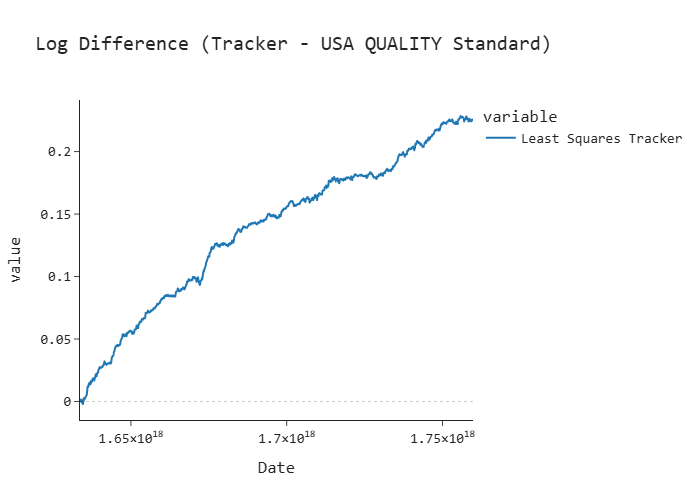

In [21]:
log_diff_df = pd.concat([
    np.log(ls_tracker_value) - np.log(index_gross_df["USA QUALITY Standard (Large+Mid Cap)"])
], axis = 1)

log_diff_df.columns = [ 
    "Least Squares Tracker"]

fig = px.line(log_diff_df, title = "Log Difference (Tracker - USA QUALITY Standard)", template = "simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))
fig.add_hline(y=0, opacity=0.2, line_width=1, line_dash='dot')
fig.show()


### USA MOMENTUM Standard

In [22]:
A = market_returns_df.values
b = index_returns_df["USA MOMENTUM Standard (Large+Mid Cap)"].values
n = A.shape[0]
m = A.shape[1]

A_close = market_price_df.values
b_gross = index_gross_df["USA MOMENTUM Standard (Large+Mid Cap)"].values
real_dates = index_gross_df.index
initial_value = b_gross[0]

In [23]:
# Formulate and solve optimization problem

w = cp.Variable(A.shape[1])

objective = cp.Minimize(cp.sum_squares(A @ w - b))
constraints = [0 <= w, cp.sum(w) == 1] # Positive weights, sum(weights) = 1.
prob = cp.Problem(objective, constraints)

prob.solve()

0.019151139267699988

In [24]:
# Fetch least squares weights
# cvxpy optimization can result in floating point inaccuracies

ls_weights = np.clip(w.value, 0, 1) # Clip weights outside [0, 1]
ls_weights /= sum(ls_weights) # Re-normalize weights

# Calculate cap-least squares tracker returns and values

ls_tracker_returns = A @ ls_weights
ls_tracker_value = initial_value * (1 + np.insert(ls_tracker_returns, 0, 0)).cumprod()
ls_tracker_value_df = pd.DataFrame({"Least Squares Tracker": ls_tracker_value}, index=real_dates)

# MSE and MAE for returns

MSE = 0
MAE = 0
for i in range(n):
    MSE += (ls_tracker_returns[i] - b[i])**2
    MAE += abs(ls_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)


MSE: 1.9123304022563438e-05
MAE: 0.0033055547318239366


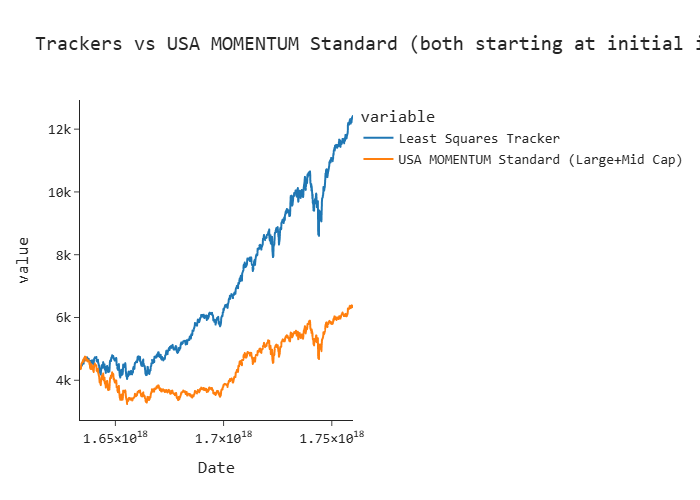

In [25]:
df_plot = pd.concat([
    ls_tracker_value_df,
    index_gross_df["USA MOMENTUM Standard (Large+Mid Cap)"]
], axis=1)

fig = px.line(df_plot, title = "Trackers vs USA MOMENTUM Standard (both starting at initial index gross)", template="simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))

fig.show()


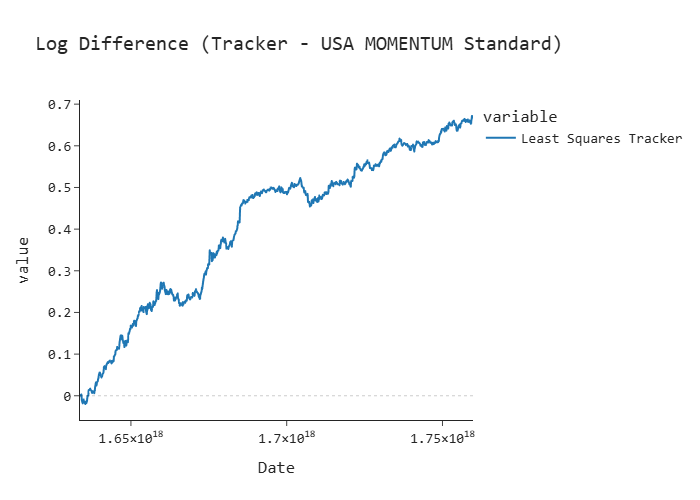

In [26]:
log_diff_df = pd.concat([
    np.log(ls_tracker_value) - np.log(index_gross_df["USA MOMENTUM Standard (Large+Mid Cap)"])
], axis = 1)

log_diff_df.columns = [ 
    "Least Squares Tracker"]

fig = px.line(log_diff_df, title = "Log Difference (Tracker - USA MOMENTUM Standard)", template = "simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))
fig.add_hline(y=0, opacity=0.2, line_width=1, line_dash='dot')
fig.show()


### MSCI USA Focus Index Standard

In [27]:
A = market_returns_df.values
b = index_returns_df["MSCI USA Focus Index Standard (Large+Mid Cap)"].values
n = A.shape[0]
m = A.shape[1]

A_close = market_price_df.values
b_gross = index_gross_df["MSCI USA Focus Index Standard (Large+Mid Cap)"].values
real_dates = index_gross_df.index
initial_value = b_gross[0]

In [28]:
# Formulate and solve optimization problem

w = cp.Variable(A.shape[1])

objective = cp.Minimize(cp.sum_squares(A @ w - b))
constraints = [0 <= w, cp.sum(w) == 1] # Positive weights, sum(weights) = 1.
prob = cp.Problem(objective, constraints)

prob.solve()

0.00037761031307788535

In [29]:
# Fetch least squares weights
# cvxpy optimization can result in floating point inaccuracies

ls_weights = np.clip(w.value, 0, 1) # Clip weights outside [0, 1]
ls_weights /= sum(ls_weights) # Re-normalize weights

# Calculate cap-least squares tracker returns and values

ls_tracker_returns = A @ ls_weights
ls_tracker_value = initial_value * (1 + np.insert(ls_tracker_returns, 0, 0)).cumprod()
ls_tracker_value_df = pd.DataFrame({"Least Squares Tracker": ls_tracker_value}, index=real_dates)

# MSE and MAE for returns

MSE = 0
MAE = 0
for i in range(n):
    MSE += (ls_tracker_returns[i] - b[i])**2
    MAE += abs(ls_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)


MSE: 3.879517715935231e-07
MAE: 0.00048754356375347116


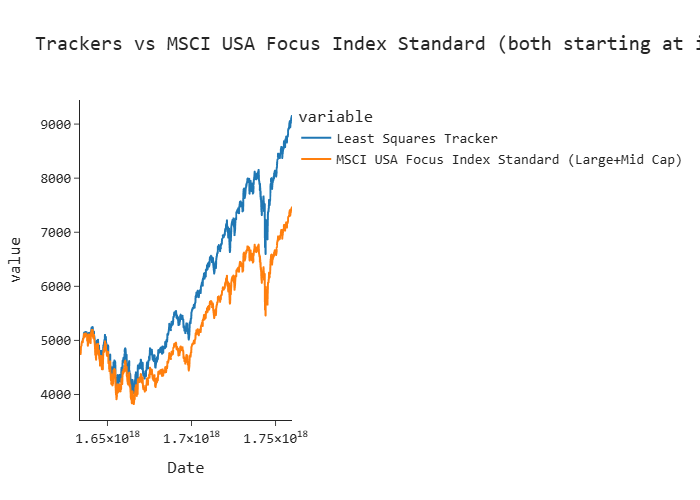

In [30]:
df_plot = pd.concat([
    ls_tracker_value_df,
    index_gross_df["MSCI USA Focus Index Standard (Large+Mid Cap)"]
], axis=1)

fig = px.line(df_plot, title = "Trackers vs MSCI USA Focus Index Standard (both starting at initial index gross)", template="simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))

fig.show()


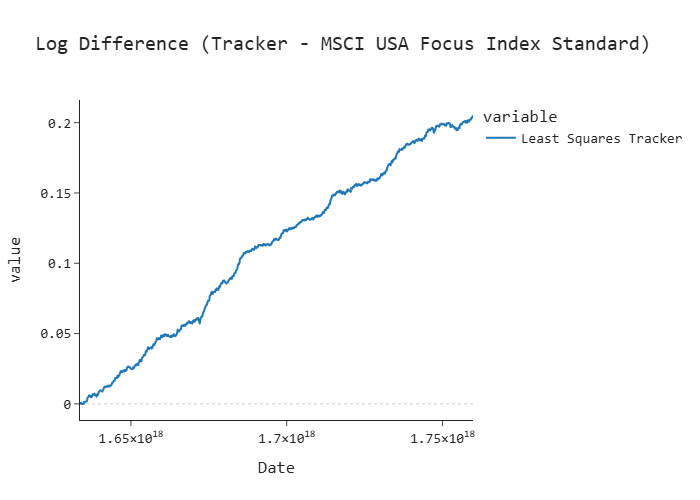

In [31]:
log_diff_df = pd.concat([
    np.log(ls_tracker_value) - np.log(index_gross_df["MSCI USA Focus Index Standard (Large+Mid Cap)"])
], axis = 1)

log_diff_df.columns = [ 
    "Least Squares Tracker"]

fig = px.line(log_diff_df, title = "Log Difference (Tracker - MSCI USA Focus Index Standard)", template = "simple_white")
fig.update_layout(font=dict(size=14, family = 'monospace'))
fig.add_hline(y=0, opacity=0.2, line_width=1, line_dash='dot')
fig.show()
